In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


(array([ 40.,  14.,  15.,  31.,  79.,  98.,  85.,  84.,  73.,  45.,  35.,
         35.,  29.,  16.,  13.,  11.,   4.,   5.,   1.,   1.]),
 array([  0.42 ,   4.399,   8.378,  12.357,  16.336,  20.315,  24.294,
         28.273,  32.252,  36.231,  40.21 ,  44.189,  48.168,  52.147,
         56.126,  60.105,  64.084,  68.063,  72.042,  76.021,  80.   ]),
 <a list of 20 Patch objects>)

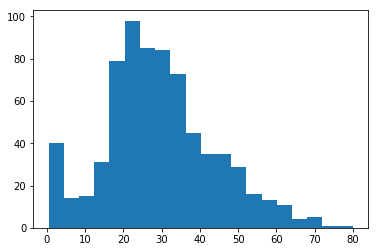

In [3]:
age = df.Age.dropna().values
plt.hist(age, bins = 'auto')

## Checking how passengers survived, by family name

In [4]:
df['l_name'] = [i.split(',')[0] for i in df.Name]
p_groups = pd.DataFrame({'fam_size' : df.groupby('l_name').size()})
p_groups['surv_mem_sum'] = df.groupby('l_name').Survived.sum()
p_groups['surv_mem_perc'] = p_groups.surv_mem_sum * 100 / p_groups.fam_size
p_groups.head()

,fam_size,surv_mem_sum,surv_mem_perc
l_name,,,
Abbing,1,0,0.0
Abbott,2,1,50.0
Abelson,2,1,50.0
Adahl,1,0,0.0
Adams,1,0,0.0


In [5]:
fam_size = pd.DataFrame({'total': p_groups.groupby('fam_size').size()})
fam_size['rate_surv'] = p_groups.groupby('fam_size').surv_mem_perc.agg(np.mean)
fam_size.head()

,total,rate_surv
fam_size,,
1,534,35.955056
2,83,52.409639
3,28,35.714286
4,14,42.857143
5,1,0.000000


In [6]:
ind = fam_size.iloc[0].rate_surv
families = fam_size.iloc[1:4].rate_surv.mean()
print(ind, families, abs(ind -families))

35.9550561798 43.66035570854848 7.70529952877


### Quick conclusions on survival, by family name:

1) Individuals were by far the biggest group of people of passengers. Follow by pairs of passengers that shared same last name.

2) Rate of survival of groups does not show mayor correlation between group size with same last name.

3) The group with the biggest survival rate are pairs, followed by groups with 4.

4) Passengers that came with their families tended to survive more (about 7.71% more).



## Checking how passengers survived by cabin and decks

In [7]:
cabs = df.dropna(subset = ['Cabin'])
cabs['deck'] = [i[:1] for i in cabs.Cabin] 
cabs['cabin'] = [i[1:] for i in cabs.Cabin]
print(len(cabs), len(df))

204 891


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


There are too many instances of missing data from the 'cabs' dataframe in the 'Deck' column. Missing data points needs to be estimated from other variables, like for example fare paid.

In [8]:
print(len(df[pd.isnull(df.Fare)]))

0


The 'Fare' variable seems to be complete. Using the 'cabs' data frame and the mean fare paid for each deck the missing data points can be estimated.

In [9]:
decks = pd.DataFrame(cabs.groupby('deck').Fare.agg(['mean', 'std', 'max', 'min']))
decks

,mean,std,max,min
deck,,,,
A,39.623887,17.975333,81.8583,0.0000
B,113.505764,109.301500,512.3292,0.0000
C,100.151341,70.225588,263.0000,26.5500
D,57.244576,29.592832,113.2750,12.8750
E,46.026694,32.608315,134.5000,8.0500
F,18.696792,11.728217,39.0000,7.6500
G,13.581250,3.601222,16.7000,10.4625
T,35.500000,NaN,35.5000,35.5000


There appears to be outliers for the data in each deck, which might create problems with the distributions. This warrants a look in depth. For example in deck A:

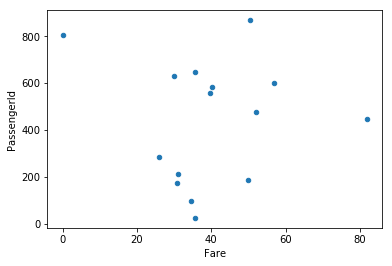

In [10]:
deck_a = cabs[cabs.deck == 'A']
deck_a.plot.scatter(x= 'Fare', y = 'PassengerId')

For this deck there seems to be two outliers. For deck B:

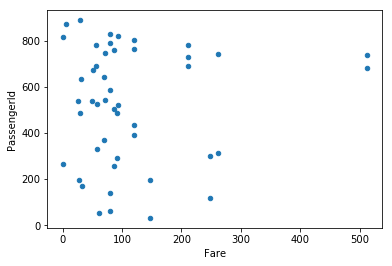

In [11]:
deck_b = cabs[cabs.deck == 'B']
deck_b.plot.scatter(x= 'Fare', y = 'PassengerId')

Having that said, the fare for each deck must filtered for these points before applying the standard deviations and mean on them.

In [12]:
deck_info = []
for i in decks.index:
    sub = cabs[cabs.deck == i]
    mean = cabs.Fare.mean()
    sd = cabs.Fare.std()
    sub = sub[sub.Fare > mean - 2*sd]
    sub = sub[sub.Fare < mean + 2*sd]
    sub = sub[sub.Fare != float(0)]
    mean = sub.Fare.mean()
    sd = sub.Fare.std()
    deck_info.append([i, mean, sd])
deck_info = pd.DataFrame(deck_info)[:7]

deck_info.columns = ['deck','m', 's']
deck_info = deck_info.set_index('deck')
deck_info

,m,s
deck,,
A,42.454164,14.784028
B,84.367203,49.286731
C,83.054323,50.386117
D,57.244576,29.592832
E,46.026694,32.608315
F,18.696792,11.728217
G,13.581250,3.601222


The means and standard deviatons changed considerably. This is considered to have the desired effect of producing a more representative information of each fare per deck. Now this will be used to determine the missing fares from the original df.

In [13]:
deck_nan = df[pd.isnull(df.Cabin)]
deck_nan = deck_nan.set_index('PassengerId')
for i in deck_info.index:
    prob = []
    mean, std = deck_info.loc[i].m, deck_info.loc[i].s
    for j in deck_nan.Fare:
        prob.append(stats.norm(mean, std).pdf(j))
    deck_nan[i] = prob
deck_nan = deck_nan.ix[:, 'A':'G']

In [14]:
print(len(deck_nan))
inf_deck = []
for i in deck_nan.index:
    passid = list(deck_nan.loc[i])
    max_p = max(passid)
    max_pos = passid.index(max_p)
    inf_deck.append(max_pos)
print(len(inf_deck))
deck_nan['inf_deck'] = ['ABCDEFG'[i] for i in inf_deck]
deck_nan.head()

687
687


,A,B,C,D,E,F,G,inf_deck
PassengerId,,,,,,,,
1,0.001584,0.002380,0.002553,0.003236,0.006033,0.021126,0.023620,G
3,0.001764,0.002431,0.002605,0.003362,0.006182,0.022310,0.032268,G
5,0.001800,0.002441,0.002615,0.003386,0.006209,0.022528,0.034056,G
6,0.001918,0.002472,0.002646,0.003464,0.006300,0.023238,0.040274,G
8,0.009485,0.003549,0.003716,0.006388,0.009129,0.033323,0.012711,F


In [15]:
df = pd.merge(df, deck_nan, right_index = True, left_on = 'PassengerId', how = 'outer')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,l_name,A,B,C,D,E,F,G,inf_deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,S,Braund,0.001584,0.002380,0.002553,0.003236,0.006033,0.021126,0.023620,G
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,C,Cumings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,S,Heikkinen,0.001764,0.002431,0.002605,0.003362,0.006182,0.022310,0.032268,G
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,S,Futrelle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,S,Allen,0.001800,0.002441,0.002615,0.003386,0.006209,0.022528,0.034056,G


In [16]:
df = df.drop('A B C D E F G'.split(), 1)

In [17]:
df.inf_deck.fillna(df.Cabin, inplace = True)
df['deck'] = [i[0] for i in df.inf_deck]



In [18]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,l_name,inf_deck,deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,G,G
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,G,G
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,C123,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,G,G


The original data frame 'df' is now complete in the column deck. Descriptive Statistics can now be applied to it.

In [19]:
decks = df.groupby('deck').size()
decks

deck
A     71
B     54
C     62
D     52
E     32
F    158
G    461
T      1
dtype: int64

To verify if this is a correct assumption, the passenger class will also be used. It is expected that decks A-B will be composed of passengers with class 1, while the rest of the decks will be composed of passengers 2-3.

In [20]:
decks_class = df.groupby(['deck', 'Pclass']).size()
decks_class

deck  Pclass
A     1          24
      2          13
      3          34
B     1          54
C     1          62
D     1          34
      2          11
      3           7
E     1          25
      2           4
      3           3
F     1          16
      2          71
      3          71
G     2          85
      3         376
T     1           1
dtype: int64

The last table shows that the distribution is not correct. There shouldnt be passengers of Pclass 2 and 3 in Deck A, which was only reserved for Pclass 1. Also, it is equally suspicious that there are passengers with Pclass 1 in Deck F. This method will be abandoned for the time being, instead the Pclass will be considered to check survival of its passengers.

## Survival by Class

In [21]:
pc = pd.DataFrame({'passangers': df.groupby(['Pclass', 'Survived']).size()})

pc

passangers
Pclass Survived            
1      0                 80
       1                136
2      0                 97
       1                 87
3      0                372
       1                119

The class of the passengers shows a more stark divde in terms of how many survived and died. In terms of percentage points:

In [22]:
pc = pd.DataFrame()

pc['surv'] = [sum(df[df.Pclass == i].Survived) for i in range(1,4)]
pc['total'] = [len(df[df.Pclass == i]) for i in range(1,4)]
pc['surv_rate'] = pc['surv'] *100 / pc['total']

pclass = range(1,4)
surv_sex = []
for i in pclass:
    df_d = df[df.Pclass == i].copy()
    df_d = pd.concat([df_d, pd.get_dummies(df_d['Sex'])], axis = 1)
    surv_sex.append([i, sum(df_d.female), sum(df_d[df_d.female == 1].Survived),sum(df_d.male), sum(df_d[df_d.male == 1].Survived)])
    
surv_sex = pd.DataFrame(surv_sex)
surv_sex.columns = ['class', 'f_tot', 'f_surv', 'm_tot', 'm_surv']
surv_sex['f_surv_rate'], surv_sex['m_surv_rate'] = surv_sex.f_surv*100 / surv_sex.f_tot, surv_sex.m_surv*100 / surv_sex.m_tot

pc['class'] = [i for i in range(1,4)]
pc = pc.set_index('class')
surv_sex.set_index('class', inplace = True)

pc = pd.merge(pc, surv_sex, left_index = True, right_index = True)
pc
    

,surv,total,surv_rate,f_tot,f_surv,m_tot,m_surv,f_surv_rate,m_surv_rate
class,,,,,,,,,
1,136,216,62.962963,94,91,122,45,96.808511,36.885246
2,87,184,47.282609,76,70,108,17,92.105263,15.740741
3,119,491,24.236253,144,72,347,47,50.000000,13.544669


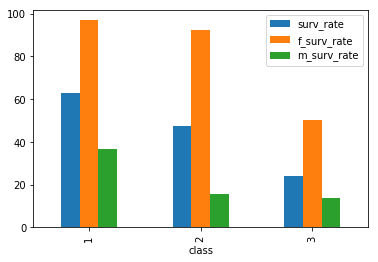

In [23]:
pc[['surv_rate', 'f_surv_rate', 'm_surv_rate']].plot.bar()

Clearly, the survival rates for women is far greater than that of men. In fact, for classes 1 and 2 the rates are almost 100%, while for the last one is 50. Contrary to that, all men sit below the 50% mark in all classes. Therefore it will be necessary to study which groups of men and women survived, based on age and class. For passengers of Class 1: 

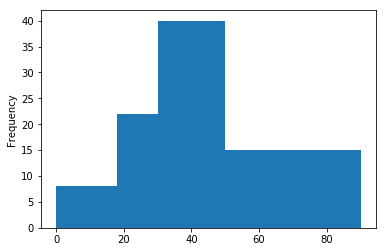

In [24]:
class1w = df[(df.Sex == 'female') & (df.Pclass == 1)]

bins = [0, 18, 30, 50, 90]
class1w.Age.plot.hist(bins = bins)

The passengers of Class 1 are mostly grouped in the age groups of 30-50 and 18-30. Now, to see how these fared in terms of survival.

In [46]:
class1w['bins'] = pd.cut(class1w.Age, bins)
groups_age_surv = pd.DataFrame({'total': class1w.groupby(['bins', 'Survived']).size()})
groups_age_surv.reset_index(inplace = True)
groups_age_surv['to'] = [sum(groups_age_surv[groups_age_surv.bins == i].total) for i in groups_age_surv.bins]
groups_age_surv['surv_rate'] = groups_age_surv.total * 100/ groups_age_surv.to
del groups_age_surv['to']
groups_age_surv

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,bins,Survived,total,to,surv_rate
0,"(0, 18]",0,1,11,9.090909
1,"(0, 18]",1,10,11,90.909091
2,"(18, 30]",0,1,24,4.166667
3,"(18, 30]",1,23,24,95.833333
4,"(30, 50]",0,1,37,2.702703
5,"(30, 50]",1,36,37,97.297297
6,"(50, 90]",1,13,13,100.000000


It appears that losses were distributed equally among all age groups and all had survability rates of over 90%. With respects to class 2:

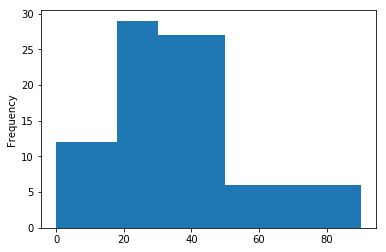

In [42]:
class2w = df[(df.Sex == 'female') & (df.Pclass == 2)]

class2w.Age.plot.hist(bins = bins)

Class 2 passengers show a shift in numbers to the age group 18-30 being the majority, followed by the those in the group 30-50. 

In [52]:
class2w['bins'] = pd.cut(class2w.Age, bins)
groups_age_surv = pd.DataFrame({'total': class2w.groupby(['bins', 'Survived']).size()})
groups_age_surv.reset_index(inplace = True)
groups_age_surv['to'] = [sum(groups_age_surv[groups_age_surv.bins == i].total) for i in groups_age_surv.bins]
groups_age_surv['surv_rate'] = groups_age_surv.total * 100/ groups_age_surv.to
del groups_age_surv['to']
groups_age_surv

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,bins,Survived,total,surv_rate
0,"(0, 18]",1,14,100.000000
1,"(18, 30]",0,3,10.000000
2,"(18, 30]",1,27,90.000000
3,"(30, 50]",0,2,7.407407
4,"(30, 50]",1,25,92.592593
5,"(50, 90]",0,1,33.333333
6,"(50, 90]",1,2,66.666667
